This notebook is a little easier for beginners because it uses pytorch. You need to clone a repo to get it working:

```sh
# you need this repo, so clone it
git clone https://github.com/wassname/DeepRL.git
cd DeepRL
git reset --hard aeae2c5d585e5853dc638968b1f090eb60abd351
cd ..
mkdir data log evaluation_log
```

This contains some minor modifications from https://github.com/ShangtongZhang/DeepRL.git

The notebook tries DPPG with the [EIIE model](https://arxiv.org/pdf/1706.10059.pdf)

I also uncommented reward normalization in DDPG_agent.py#L64 because otherwise my small reward les to large Q's, inf losses, and NaN actions and weights.

In [1]:
# plotting
%matplotlib notebook
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# numeric
import numpy as np
from numpy import random
import pandas as pd

# utils
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import tempfile
import logging
import time
import datetime

# logging
logger = log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

# bot
try:
    import results_bot_personal as rbot
except ModuleNotFoundError:
    import results_bot as rbot
try:
    resultsBot = rbot.ResultsBot(rbot.bot_api, rbot.chat_id)
except TelegramError:
    print('Have you set up bot details?')

INFO:__main__:__main__ logger started.


In [2]:
import os
os.sys.path.append(os.path.abspath('.'))
os.sys.path.append(os.path.abspath('DeepRL'))
%reload_ext autoreload
%autoreload 2

In [3]:
# params
window_length = 50
steps = 128



In [4]:
# save dir
import datetime
ts = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')

save_path = './outputs/pytorch-DDPG/pytorch-DDPG-EIIE-action-crypto-%s.model' % ts
save_path
try:
    os.makedirs(os.path.dirname(save_path))
except OSError:
    pass

In [5]:
# setup tensorboard logging
from tensorboard_logger import configure, log_value
tag = 'ddpg-' + ts
print('tensorboard --logdir '+"runs/" + tag)
try:
    configure("runs/" + tag)
except ValueError as e:
    print(e)
    pass

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


tensorboard --logdir runs/ddpg-20180402_15-43-32


# Env

In [6]:
from rl_portfolio_management.environments.portfolio import PortfolioEnv
from rl_portfolio_management.util import MDD, sharpe, softmax
from rl_portfolio_management.wrappers import SoftmaxActions, TransposeHistory, ConcatStates

df_train = pd.read_hdf('./data/bloomberg_30m.hf',key='train')
df_test = pd.read_hdf('./data/bloomberg_30m.hf',key='test')


In [7]:
import gym
class DeepRLWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.render_on_reset = False
        
        self.state_dim = self.observation_space.shape
        self.action_dim = self.action_space.shape[0]
        
        self.name = 'PortfolioEnv'
        self.success_threshold = 2
        
    def normalize_state(self, state):
        return state
    
    def step(self, action):
        state, reward, done, info =self.env.step(action)
        reward*=1e4 # often reward scaling is important sooo...
        return state, reward, done, info
    
    def reset(self):        
        # here's a roundabout way to get it to plot on reset
        if self.render_on_reset: 
            self.env.render('notebook')

        return self.env.reset()

In [8]:
def task_fn():
    env = PortfolioEnv(df=df_train, steps=steps, output_mode='EIIE')
    env = TransposeHistory(env)
    env = ConcatStates(env)
    env = SoftmaxActions(env)
    env = DeepRLWrapper(env)
    return env

def task_fn_test():
    env = PortfolioEnv(df=df_test, steps=steps, output_mode='EIIE')
    env = TransposeHistory(env)
    env = ConcatStates(env)
    env = SoftmaxActions(env)
    env = DeepRLWrapper(env)
    return env
    
# sanity check
task = task_fn()
task.reset().shape, task.step(task.action_space.sample())[0].shape

((4, 51, 16), (4, 51, 16))

# Agent and models

In [9]:
# load
import pickle
import shutil

def save_ddpg(agent):
    agent_type = agent.__class__.__name__
    save_file = 'data/%s-%s-model-%s.bin' % (agent_type, config.tag, agent.task.name)
    agent.save(save_file)
    print(save_file)
    

def load_ddpg(agent):
    agent_type = agent.__class__.__name__
    save_file = 'data/%s-%s-model-%s.bin' % (agent_type, config.tag, agent.task.name)
    new_states = pickle.load(open(save_file, 'rb'))
    states = agent.worker_network.load_state_dict(new_states)


def load_stats_ddpg(agent):
    agent_type = agent.__class__.__name__
    online_stats_file = 'data/%s-%s-online-stats-%s.bin' % (
                    agent_type, config.tag, agent.task.name)
    try:
        steps, rewards = pickle.load(open(online_stats_file, 'rb'))
    except FileNotFoundError:
        steps =[]
        rewards=[]
    df_online = pd.DataFrame(np.array([steps, rewards]).T, columns=['steps','rewards'])
    if len(df_online):
        df_online['step'] = df_online['steps'].cumsum()
        df_online.index.name = 'episodes'
    
    stats_file = 'data/%s-%s-all-stats-%s.bin' % (agent_type, config.tag, agent.task.name)
    try:
        stats = pickle.load(open(stats_file, 'rb'))
    except FileNotFoundError:
        stats = {}
    df = pd.DataFrame(stats["test_rewards"], columns=['rewards'])
    if len(df):
#         df["steps"]=range(len(df))*50

        df.index.name = 'episodes'
    return df_online, df

In [10]:
import logging
from agent import ProximalPolicyOptimization, DisjointActorCriticNet #, DeterministicActorNet, DeterministicCriticNet
from component import GaussianPolicy, HighDimActionReplay, OrnsteinUhlenbeckProcess
from utils import Config, Logger
import gym
import torch
gym.logger.setLevel(logging.INFO)

# Alg

In [11]:
# Modified from https://github.com/ShangtongZhang/DeepRL to log to tensorboard

from utils.normalizer import Normalizer

null_normaliser = lambda x:x

class DDPGAgent:
    def __init__(self, config):
        self.config = config
        self.task = config.task_fn()
        self.worker_network = config.network_fn()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.worker_network.state_dict())
        self.actor_opt = config.actor_optimizer_fn(self.worker_network.actor.parameters())
        self.critic_opt = config.critic_optimizer_fn(self.worker_network.critic.parameters())
        self.replay = config.replay_fn()
        self.random_process = config.random_process_fn()
        self.criterion = nn.MSELoss()
        self.total_steps = 0

        self.state_normalizer = Normalizer(self.task.state_dim) # null_normaliser # 
        self.reward_normalizer = Normalizer(1)

    def soft_update(self, target, src):
        for target_param, param in zip(target.parameters(), src.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.config.target_network_mix) +
                                    param.data * self.config.target_network_mix)

    def save(self, file_name):
        with open(file_name, 'wb') as f:
            torch.save(self.worker_network.state_dict(), f)

    def episode(self, deterministic=False, video_recorder=None):
        self.random_process.reset_states()
        state = self.task.reset()
        state = self.state_normalizer(state)

        config = self.config
        actor = self.worker_network.actor
        critic = self.worker_network.critic
        target_actor = self.target_network.actor
        target_critic = self.target_network.critic

        steps = 0
        total_reward = 0.0
        while True:
            actor.eval()
            action = actor.predict(np.stack([state])).flatten()
            if not deterministic:
                action += self.random_process.sample()
            next_state, reward, done, info = self.task.step(action)
            if video_recorder is not None:
                video_recorder.capture_frame()
            done = (done or (config.max_episode_length and steps >= config.max_episode_length))
            next_state = self.state_normalizer(next_state) * config.reward_scaling
            total_reward += reward
            
            # tensorboard logging
            prefix = 'test_' if deterministic else ''
            log_value(prefix + 'reward', reward, self.total_steps)
#             log_value(prefix + 'action', action, steps)
            log_value('memory_size', self.replay.size(), self.total_steps)     
            for key in info:
                log_value(key, info[key], self.total_steps)     
            
            reward = self.reward_normalizer(reward)

            if not deterministic:
                self.replay.feed([state, action, reward, next_state, int(done)])
                self.total_steps += 1

            steps += 1
            state = next_state

            if done:
                break

            if not deterministic and self.replay.size() >= config.min_memory_size:
                self.worker_network.train()
                experiences = self.replay.sample()
                states, actions, rewards, next_states, terminals = experiences
                q_next = target_critic.predict(next_states, target_actor.predict(next_states))
                terminals = critic.to_torch_variable(terminals).unsqueeze(1)
                rewards = critic.to_torch_variable(rewards).unsqueeze(1)
                q_next = config.discount * q_next * (1 - terminals)
                q_next.add_(rewards)
                q_next = q_next.detach()
                q = critic.predict(states, actions)
                critic_loss = self.criterion(q, q_next)

                critic.zero_grad()
                self.critic_opt.zero_grad()
                critic_loss.backward()
                if config.gradient_clip:
                    grad_critic = nn.utils.clip_grad_norm(self.worker_network.parameters(), config.gradient_clip)
                self.critic_opt.step()

                actions = actor.predict(states, False)
                var_actions = Variable(actions.data, requires_grad=True)
                q = critic.predict(states, var_actions)
                q.backward(torch.ones(q.size()))

                actor.zero_grad()
                self.actor_opt.zero_grad()
                actions.backward(-var_actions.grad.data)
                if config.gradient_clip:
                    grad_actor = nn.utils.clip_grad_norm(self.worker_network.parameters(), config.gradient_clip)
                self.actor_opt.step()
                
                # tensorboard logging
                log_value('critic_loss', critic_loss.cpu().data.numpy().squeeze(), self.total_steps)
                log_value('loss_action', -q.sum(), self.total_steps)
                if config.gradient_clip:
                    log_value('grad_critic', grad_critic, self.total_steps)
                    log_value('grad_actor', grad_actor, self.total_steps)

                self.soft_update(self.target_network, self.worker_network)

        return total_reward, steps

# Model

In [12]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [13]:
task.state_dim, task.action_dim

((4, 51, 16), 17)

In [14]:

from network.base_network import BasicNet

class DeterministicActorNet(nn.Module, BasicNet):
    def __init__(self,
                 state_dim,
                 action_dim,
                 action_gate,
                 action_scale,
                 gpu=False,
                 batch_norm=False,
                 non_linear=F.relu):
        super(DeterministicActorNet, self).__init__()

        stride_time = state_dim[1] - 1 - 2 #
        features = task.state_dim[0]
        h0 = 2
        h1 = 30
        self.conv1 = nn.Conv2d(features, h0, (3, 1))
        self.conv2 = nn.Conv2d(h0, h1, (stride_time, 1), stride=(stride_time, 1))
        self.conv3 = nn.Conv2d((h1+1), 1, (1, 1))

        self.action_scale = action_scale
        self.action_gate = action_gate
        self.non_linear = non_linear

        if batch_norm:
            self.bn1 = nn.BatchNorm1d(h0)
            self.bn2 = nn.BatchNorm1d(h1)

        self.batch_norm = batch_norm
        BasicNet.__init__(self, None, gpu, False)


    def forward(self, x):
        x = self.to_torch_variable(x)
        
        w0 = x[:,:1,:1,:] # weights from last step 
        x = x[:,:,1:,:]
        
        phi0 = self.non_linear(self.conv1(x))
        if self.batch_norm:
            phi0 = self.bn1(phi0)
        phi1 = self.non_linear(self.conv2(phi0))
        h = torch.cat([phi1,w0], 1)
        if self.batch_norm:
            h = self.bn2(h)
        
        action = self.conv3(h)
        
        # add cash_bias before we softmax
        cash_bias_int = 0
        cash_bias = self.to_torch_variable(torch.ones(action.size())[:,:,:,:1] * cash_bias_int)
        action = torch.cat([cash_bias, action], -1)
        
        batch_size = action.size()[0]
        action = action.view((batch_size,-1))
        if self.action_gate:
            action = self.action_scale * self.action_gate(action)
        return action

    def predict(self, x, to_numpy=True):
        y = self.forward(x)
        if to_numpy:
            y = y.cpu().data.numpy()
        return y

class DeterministicCriticNet(nn.Module, BasicNet):
    def __init__(self,
                 state_dim,
                 action_dim,
                 gpu=False,
                 batch_norm=False,
                 non_linear=F.relu):
        super(DeterministicCriticNet, self).__init__()
        stride_time = state_dim[1] - 1 - 2 #
        self.features = features = task.state_dim[0]
        h0=2
        h1=20
        self.action = actions = action_dim -1
        self.conv1 = nn.Conv2d(features, h0, (3, 1))
        self.conv2 = nn.Conv2d(h0, h1, (stride_time, 1), stride=(stride_time, 1))
        self.layer3 = nn.Linear((h1+2)*actions, 1)
        self.non_linear = non_linear

        if batch_norm:
            self.bn1 = nn.BatchNorm1d(h0)
            self.bn2 = nn.BatchNorm1d(h1)
        self.batch_norm = batch_norm

        BasicNet.__init__(self, None, gpu, False)


    def forward(self, x, action):
        x = self.to_torch_variable(x)
        action = self.to_torch_variable(action)[:,None,None,:-1] # remove cash bias
        
        w0 = x[:,:1,:1,:] # weights from last step 
        x = x[:,:,1:,:]
        
        phi0 = self.non_linear(self.conv1(x))
        if self.batch_norm:
            phi0 = self.bn1(phi0)
        phi1 = self.non_linear(self.conv2(phi0))
        h = torch.cat([phi1,w0,action], 1)
        if self.batch_norm:
            h = self.bn2(h)
        
        batch_size = x.size()[0]
        action = self.layer3(h.view((batch_size,-1)))
        return action

    def predict(self, x, action):
        return self.forward(x, action)

# Config

In [15]:
config = Config()
config.task_fn = task_fn
task = config.task_fn()
config.actor_network_fn = lambda: DeterministicActorNet(
    task.state_dim, task.action_dim, action_gate=None, action_scale=1.0, non_linear=F.relu, batch_norm=False, gpu=False)
config.critic_network_fn = lambda: DeterministicCriticNet(
    task.state_dim, task.action_dim, non_linear=F.relu, batch_norm=False, gpu=False)
config.network_fn = lambda: DisjointActorCriticNet(config.actor_network_fn, config.critic_network_fn)
config.actor_optimizer_fn = lambda params: torch.optim.Adam(params, lr=4e-5)
config.critic_optimizer_fn =\
    lambda params: torch.optim.Adam(params, lr=5e-4, weight_decay=0.001)
config.replay_fn = lambda: HighDimActionReplay(memory_size=600, batch_size=64)
config.random_process_fn = \
    lambda: OrnsteinUhlenbeckProcess(size=task.action_dim, theta=0.15, sigma=0.2, sigma_min=0.00002, n_steps_annealing=10000)
config.discount = 0.0

# Test
config.exploration_steps = 1000

config.min_memory_size = 50
config.target_network_mix = 0.001
config.max_steps = 100000
config.max_episode_length = 3000
config.target_network_mix = 0.01
config.noise_decay_interval = 100000
config.gradient_clip = 20
config.min_epsilon = 0.1

# Many papers have found rewards scaling to be an important parameter. But while they focus on the scaling factor
# I think they should focus on the end variance with a range of 200-400. e.g. https://arxiv.org/pdf/1709.06560.pdf
# Hard to tell for sure without experiments to prove it
config.reward_scaling = 1000

config.test_interval = 10
config.test_repetitions = 1
config.save_interval = 40
config.logger = Logger('./log', gym.logger)
config.tag = tag
agent = DDPGAgent(config)
agent

# Train

In [16]:
from main import run_episodes
agent.task._plot = agent.task._plot2 = None
try:    
    run_episodes(agent)
except KeyboardInterrupt as e:
    save_ddpg(agent)
    raise(e)

INFO:gym:episode 1, reward -1.011887, avg reward -1.011887, total steps 128, episode step 128
[2018-04-02 16:43:39,988] episode 1, reward -1.011887, avg reward -1.011887, total steps 128, episode step 128
INFO:gym:episode 2, reward -0.160929, avg reward -0.586408, total steps 256, episode step 128
[2018-04-02 16:43:44,209] episode 2, reward -0.160929, avg reward -0.586408, total steps 256, episode step 128
INFO:gym:episode 3, reward -0.249178, avg reward -0.473998, total steps 384, episode step 128
[2018-04-02 16:43:47,886] episode 3, reward -0.249178, avg reward -0.473998, total steps 384, episode step 128
INFO:gym:episode 4, reward -0.299910, avg reward -0.430476, total steps 512, episode step 128
[2018-04-02 16:43:51,640] episode 4, reward -0.299910, avg reward -0.430476, total steps 512, episode step 128
INFO:gym:episode 5, reward 0.916383, avg reward -0.161104, total steps 640, episode step 128
[2018-04-02 16:43:55,675] episode 5, reward 0.916383, avg reward -0.161104, total steps

[2018-04-02 16:46:19,746] episode 38, reward -0.026070, avg reward -0.484872, total steps 4864, episode step 128
INFO:gym:episode 39, reward -0.280506, avg reward -0.479632, total steps 4992, episode step 128
[2018-04-02 16:46:23,756] episode 39, reward -0.280506, avg reward -0.479632, total steps 4992, episode step 128
INFO:gym:episode 40, reward 2.083829, avg reward -0.415546, total steps 5120, episode step 128
[2018-04-02 16:46:27,437] episode 40, reward 2.083829, avg reward -0.415546, total steps 5120, episode step 128
INFO:gym:Testing...
[2018-04-02 16:46:27,440] Testing...
INFO:gym:Avg reward -0.392516(0.000000)
[2018-04-02 16:46:28,563] Avg reward -0.392516(0.000000)
INFO:gym:episode 41, reward -0.379280, avg reward -0.414661, total steps 5248, episode step 128
[2018-04-02 16:46:32,796] episode 41, reward -0.379280, avg reward -0.414661, total steps 5248, episode step 128
INFO:gym:episode 42, reward -2.810273, avg reward -0.471700, total steps 5376, episode step 128
[2018-04-02 

INFO:gym:episode 75, reward -1.954269, avg reward -0.337516, total steps 9600, episode step 128
[2018-04-02 16:48:49,220] episode 75, reward -1.954269, avg reward -0.337516, total steps 9600, episode step 128
INFO:gym:episode 76, reward -0.356150, avg reward -0.337761, total steps 9728, episode step 128
[2018-04-02 16:48:52,832] episode 76, reward -0.356150, avg reward -0.337761, total steps 9728, episode step 128
INFO:gym:episode 77, reward -0.311194, avg reward -0.337416, total steps 9856, episode step 128
[2018-04-02 16:48:56,423] episode 77, reward -0.311194, avg reward -0.337416, total steps 9856, episode step 128
INFO:gym:episode 78, reward -0.294189, avg reward -0.336862, total steps 9984, episode step 128
[2018-04-02 16:49:00,027] episode 78, reward -0.294189, avg reward -0.336862, total steps 9984, episode step 128
INFO:gym:episode 79, reward -0.223827, avg reward -0.335431, total steps 10112, episode step 128
[2018-04-02 16:49:03,647] episode 79, reward -0.223827, avg reward 

[2018-04-02 16:51:10,905] episode 111, reward 0.672139, avg reward -0.195280, total steps 14208, episode step 128
INFO:gym:episode 112, reward -0.977682, avg reward -0.202165, total steps 14336, episode step 128
[2018-04-02 16:51:14,517] episode 112, reward -0.977682, avg reward -0.202165, total steps 14336, episode step 128
INFO:gym:episode 113, reward 1.723347, avg reward -0.182266, total steps 14464, episode step 128
[2018-04-02 16:51:18,250] episode 113, reward 1.723347, avg reward -0.182266, total steps 14464, episode step 128
INFO:gym:episode 114, reward 1.474507, avg reward -0.164385, total steps 14592, episode step 128
[2018-04-02 16:51:21,891] episode 114, reward 1.474507, avg reward -0.164385, total steps 14592, episode step 128
INFO:gym:episode 115, reward -1.247366, avg reward -0.173463, total steps 14720, episode step 128
[2018-04-02 16:51:25,513] episode 115, reward -1.247366, avg reward -0.173463, total steps 14720, episode step 128
INFO:gym:episode 116, reward 1.497436,

INFO:gym:episode 148, reward 0.647714, avg reward -0.045912, total steps 18944, episode step 128
[2018-04-02 16:53:29,033] episode 148, reward 0.647714, avg reward -0.045912, total steps 18944, episode step 128
INFO:gym:episode 149, reward 0.707531, avg reward -0.035473, total steps 19072, episode step 128
[2018-04-02 16:53:32,682] episode 149, reward 0.707531, avg reward -0.035473, total steps 19072, episode step 128
INFO:gym:episode 150, reward 0.929868, avg reward -0.023656, total steps 19200, episode step 128
[2018-04-02 16:53:36,380] episode 150, reward 0.929868, avg reward -0.023656, total steps 19200, episode step 128
INFO:gym:Testing...
[2018-04-02 16:53:36,381] Testing...
INFO:gym:Avg reward -0.395387(0.000000)
[2018-04-02 16:53:37,498] Avg reward -0.395387(0.000000)
INFO:gym:episode 151, reward -0.364646, avg reward -0.024945, total steps 19328, episode step 128
[2018-04-02 16:53:41,111] episode 151, reward -0.364646, avg reward -0.024945, total steps 19328, episode step 128


[2018-04-02 16:55:44,188] episode 184, reward 0.360360, avg reward 0.337412, total steps 23552, episode step 128
INFO:gym:episode 185, reward -0.568982, avg reward 0.336972, total steps 23680, episode step 128
[2018-04-02 16:55:47,837] episode 185, reward -0.568982, avg reward 0.336972, total steps 23680, episode step 128
INFO:gym:episode 186, reward 0.885268, avg reward 0.358838, total steps 23808, episode step 128
[2018-04-02 16:55:51,442] episode 186, reward 0.885268, avg reward 0.358838, total steps 23808, episode step 128
INFO:gym:episode 187, reward -0.011500, avg reward 0.375049, total steps 23936, episode step 128
[2018-04-02 16:55:55,061] episode 187, reward -0.011500, avg reward 0.375049, total steps 23936, episode step 128
INFO:gym:episode 188, reward 0.268432, avg reward 0.361490, total steps 24064, episode step 128
[2018-04-02 16:55:58,675] episode 188, reward 0.268432, avg reward 0.361490, total steps 24064, episode step 128
INFO:gym:episode 189, reward 0.270771, avg rewa

[2018-04-02 16:59:01,975] Avg reward 1.458273(0.000000)
INFO:gym:episode 221, reward 1.786392, avg reward 0.436391, total steps 28288, episode step 128
[2018-04-02 16:59:09,384] episode 221, reward 1.786392, avg reward 0.436391, total steps 28288, episode step 128
INFO:gym:episode 222, reward 0.343376, avg reward 0.440458, total steps 28416, episode step 128
[2018-04-02 16:59:16,694] episode 222, reward 0.343376, avg reward 0.440458, total steps 28416, episode step 128
INFO:gym:episode 223, reward -1.959619, avg reward 0.424755, total steps 28544, episode step 128
[2018-04-02 16:59:23,919] episode 223, reward -1.959619, avg reward 0.424755, total steps 28544, episode step 128
INFO:gym:episode 224, reward 0.274913, avg reward 0.431491, total steps 28672, episode step 128
[2018-04-02 16:59:30,928] episode 224, reward 0.274913, avg reward 0.431491, total steps 28672, episode step 128
INFO:gym:episode 225, reward 2.483060, avg reward 0.444440, total steps 28800, episode step 128
[2018-04-0

INFO:gym:episode 258, reward -1.538431, avg reward 0.602644, total steps 33024, episode step 128
[2018-04-02 17:03:09,336] episode 258, reward -1.538431, avg reward 0.602644, total steps 33024, episode step 128
INFO:gym:episode 259, reward 1.466925, avg reward 0.602371, total steps 33152, episode step 128
[2018-04-02 17:03:12,945] episode 259, reward 1.466925, avg reward 0.602371, total steps 33152, episode step 128
INFO:gym:episode 260, reward 1.762389, avg reward 0.624371, total steps 33280, episode step 128
[2018-04-02 17:03:16,528] episode 260, reward 1.762389, avg reward 0.624371, total steps 33280, episode step 128
INFO:gym:Testing...
[2018-04-02 17:03:16,529] Testing...
INFO:gym:Avg reward 1.081030(0.000000)
[2018-04-02 17:03:17,681] Avg reward 1.081030(0.000000)
INFO:gym:episode 261, reward 1.275247, avg reward 0.630825, total steps 33408, episode step 128
[2018-04-02 17:03:21,389] episode 261, reward 1.275247, avg reward 0.630825, total steps 33408, episode step 128
INFO:gym:e

[2018-04-02 17:06:09,745] episode 294, reward 1.095461, avg reward 0.638738, total steps 37632, episode step 128
INFO:gym:episode 295, reward 1.053483, avg reward 0.640330, total steps 37760, episode step 128
[2018-04-02 17:06:17,039] episode 295, reward 1.053483, avg reward 0.640330, total steps 37760, episode step 128
INFO:gym:episode 296, reward -1.375759, avg reward 0.642122, total steps 37888, episode step 128
[2018-04-02 17:06:24,256] episode 296, reward -1.375759, avg reward 0.642122, total steps 37888, episode step 128
INFO:gym:episode 297, reward 0.931281, avg reward 0.650469, total steps 38016, episode step 128
[2018-04-02 17:06:31,656] episode 297, reward 0.931281, avg reward 0.650469, total steps 38016, episode step 128
INFO:gym:episode 298, reward 0.362902, avg reward 0.649441, total steps 38144, episode step 128
[2018-04-02 17:06:39,171] episode 298, reward 0.362902, avg reward 0.649441, total steps 38144, episode step 128
INFO:gym:episode 299, reward 2.936600, avg reward

[2018-04-02 17:10:35,682] Avg reward 1.107848(0.000000)
INFO:gym:episode 331, reward 0.523539, avg reward 0.541619, total steps 42368, episode step 128
[2018-04-02 17:10:43,376] episode 331, reward 0.523539, avg reward 0.541619, total steps 42368, episode step 128
INFO:gym:episode 332, reward -1.759474, avg reward 0.510147, total steps 42496, episode step 128
[2018-04-02 17:10:48,958] episode 332, reward -1.759474, avg reward 0.510147, total steps 42496, episode step 128
INFO:gym:episode 333, reward 0.240960, avg reward 0.496897, total steps 42624, episode step 128
[2018-04-02 17:10:55,913] episode 333, reward 0.240960, avg reward 0.496897, total steps 42624, episode step 128
INFO:gym:episode 334, reward 2.016589, avg reward 0.519242, total steps 42752, episode step 128
[2018-04-02 17:11:03,686] episode 334, reward 2.016589, avg reward 0.519242, total steps 42752, episode step 128
INFO:gym:episode 335, reward 0.345425, avg reward 0.514173, total steps 42880, episode step 128
[2018-04-0

INFO:gym:episode 368, reward 0.931341, avg reward 0.312460, total steps 47104, episode step 128
[2018-04-02 17:14:15,814] episode 368, reward 0.931341, avg reward 0.312460, total steps 47104, episode step 128
INFO:gym:episode 369, reward -1.402240, avg reward 0.282606, total steps 47232, episode step 128
[2018-04-02 17:14:20,999] episode 369, reward -1.402240, avg reward 0.282606, total steps 47232, episode step 128
INFO:gym:episode 370, reward -0.522246, avg reward 0.274144, total steps 47360, episode step 128
[2018-04-02 17:14:26,146] episode 370, reward -0.522246, avg reward 0.274144, total steps 47360, episode step 128
INFO:gym:Testing...
[2018-04-02 17:14:26,147] Testing...
INFO:gym:Avg reward -0.479314(0.000000)
[2018-04-02 17:14:27,248] Avg reward -0.479314(0.000000)
INFO:gym:episode 371, reward -1.352339, avg reward 0.233848, total steps 47488, episode step 128
[2018-04-02 17:14:32,631] episode 371, reward -1.352339, avg reward 0.233848, total steps 47488, episode step 128
INFO

[2018-04-02 17:18:57,203] episode 404, reward 1.383909, avg reward 0.298839, total steps 51712, episode step 128
INFO:gym:episode 405, reward -0.638056, avg reward 0.286964, total steps 51840, episode step 128
[2018-04-02 17:19:02,978] episode 405, reward -0.638056, avg reward 0.286964, total steps 51840, episode step 128
INFO:gym:episode 406, reward -1.156972, avg reward 0.256788, total steps 51968, episode step 128
[2018-04-02 17:19:08,840] episode 406, reward -1.156972, avg reward 0.256788, total steps 51968, episode step 128
INFO:gym:episode 407, reward 0.818328, avg reward 0.281206, total steps 52096, episode step 128
[2018-04-02 17:19:14,897] episode 407, reward 0.818328, avg reward 0.281206, total steps 52096, episode step 128
INFO:gym:episode 408, reward -0.062216, avg reward 0.281371, total steps 52224, episode step 128
[2018-04-02 17:19:20,828] episode 408, reward -0.062216, avg reward 0.281371, total steps 52224, episode step 128
INFO:gym:episode 409, reward 2.431803, avg re

[2018-04-02 17:23:28,140] Avg reward 1.483414(0.000000)
INFO:gym:episode 441, reward 1.160915, avg reward 0.432938, total steps 56448, episode step 128
[2018-04-02 17:23:33,815] episode 441, reward 1.160915, avg reward 0.432938, total steps 56448, episode step 128
INFO:gym:episode 442, reward -1.366613, avg reward 0.439793, total steps 56576, episode step 128
[2018-04-02 17:23:38,825] episode 442, reward -1.366613, avg reward 0.439793, total steps 56576, episode step 128
INFO:gym:episode 443, reward 1.485871, avg reward 0.454018, total steps 56704, episode step 128
[2018-04-02 17:23:43,887] episode 443, reward 1.485871, avg reward 0.454018, total steps 56704, episode step 128
INFO:gym:episode 444, reward -2.303332, avg reward 0.422225, total steps 56832, episode step 128
[2018-04-02 17:23:48,970] episode 444, reward -2.303332, avg reward 0.422225, total steps 56832, episode step 128
INFO:gym:episode 445, reward 2.010002, avg reward 0.457800, total steps 56960, episode step 128
[2018-04

INFO:gym:episode 478, reward 1.574954, avg reward 0.593097, total steps 61184, episode step 128
[2018-04-02 17:27:17,997] episode 478, reward 1.574954, avg reward 0.593097, total steps 61184, episode step 128
INFO:gym:episode 479, reward 1.305236, avg reward 0.600909, total steps 61312, episode step 128
[2018-04-02 17:27:25,734] episode 479, reward 1.305236, avg reward 0.600909, total steps 61312, episode step 128
INFO:gym:episode 480, reward 0.955569, avg reward 0.608197, total steps 61440, episode step 128
[2018-04-02 17:27:33,743] episode 480, reward 0.955569, avg reward 0.608197, total steps 61440, episode step 128
INFO:gym:Testing...
[2018-04-02 17:27:33,748] Testing...
INFO:gym:Avg reward -0.237457(0.000000)
[2018-04-02 17:27:34,860] Avg reward -0.237457(0.000000)
INFO:gym:episode 481, reward 1.001919, avg reward 0.610889, total steps 61568, episode step 128
[2018-04-02 17:27:42,896] episode 481, reward 1.001919, avg reward 0.610889, total steps 61568, episode step 128
INFO:gym:e

[2018-04-02 17:32:17,635] episode 514, reward 0.866016, avg reward 0.481111, total steps 65792, episode step 128
INFO:gym:episode 515, reward -0.096259, avg reward 0.471949, total steps 65920, episode step 128
[2018-04-02 17:32:24,585] episode 515, reward -0.096259, avg reward 0.471949, total steps 65920, episode step 128
INFO:gym:episode 516, reward -1.923452, avg reward 0.458708, total steps 66048, episode step 128
[2018-04-02 17:32:31,268] episode 516, reward -1.923452, avg reward 0.458708, total steps 66048, episode step 128
INFO:gym:episode 517, reward 1.358298, avg reward 0.456668, total steps 66176, episode step 128
[2018-04-02 17:32:37,660] episode 517, reward 1.358298, avg reward 0.456668, total steps 66176, episode step 128
INFO:gym:episode 518, reward 1.377099, avg reward 0.458142, total steps 66304, episode step 128
[2018-04-02 17:32:45,019] episode 518, reward 1.377099, avg reward 0.458142, total steps 66304, episode step 128
INFO:gym:episode 519, reward 0.054573, avg rewa

[2018-04-02 17:36:11,463] Avg reward -0.659542(0.000000)
INFO:gym:episode 551, reward 0.723737, avg reward 0.563763, total steps 70528, episode step 128
[2018-04-02 17:36:16,910] episode 551, reward 0.723737, avg reward 0.563763, total steps 70528, episode step 128
INFO:gym:episode 552, reward -0.139945, avg reward 0.555392, total steps 70656, episode step 128
[2018-04-02 17:36:22,389] episode 552, reward -0.139945, avg reward 0.555392, total steps 70656, episode step 128
INFO:gym:episode 553, reward 1.402315, avg reward 0.571297, total steps 70784, episode step 128
[2018-04-02 17:36:27,859] episode 553, reward 1.402315, avg reward 0.571297, total steps 70784, episode step 128
INFO:gym:episode 554, reward -0.638422, avg reward 0.552196, total steps 70912, episode step 128
[2018-04-02 17:36:33,300] episode 554, reward -0.638422, avg reward 0.552196, total steps 70912, episode step 128
INFO:gym:episode 555, reward -0.233531, avg reward 0.554917, total steps 71040, episode step 128
[2018-

INFO:gym:episode 588, reward 1.178563, avg reward 0.505697, total steps 75264, episode step 128
[2018-04-02 17:40:30,219] episode 588, reward 1.178563, avg reward 0.505697, total steps 75264, episode step 128
INFO:gym:episode 589, reward 1.064458, avg reward 0.508315, total steps 75392, episode step 128
[2018-04-02 17:40:39,541] episode 589, reward 1.064458, avg reward 0.508315, total steps 75392, episode step 128
INFO:gym:episode 590, reward 0.894870, avg reward 0.529804, total steps 75520, episode step 128
[2018-04-02 17:40:48,932] episode 590, reward 0.894870, avg reward 0.529804, total steps 75520, episode step 128
INFO:gym:Testing...
[2018-04-02 17:40:48,934] Testing...
INFO:gym:Avg reward 2.703517(0.000000)
[2018-04-02 17:40:50,036] Avg reward 2.703517(0.000000)
INFO:gym:episode 591, reward 0.351881, avg reward 0.517254, total steps 75648, episode step 128
[2018-04-02 17:40:59,664] episode 591, reward 0.351881, avg reward 0.517254, total steps 75648, episode step 128
INFO:gym:epi

[2018-04-02 17:44:59,481] episode 624, reward -1.619307, avg reward 0.652157, total steps 79872, episode step 128
INFO:gym:episode 625, reward 1.247716, avg reward 0.670204, total steps 80000, episode step 128
[2018-04-02 17:45:05,004] episode 625, reward 1.247716, avg reward 0.670204, total steps 80000, episode step 128
INFO:gym:episode 626, reward 2.400082, avg reward 0.680877, total steps 80128, episode step 128
[2018-04-02 17:45:09,941] episode 626, reward 2.400082, avg reward 0.680877, total steps 80128, episode step 128
INFO:gym:episode 627, reward 1.291233, avg reward 0.706548, total steps 80256, episode step 128
[2018-04-02 17:45:14,867] episode 627, reward 1.291233, avg reward 0.706548, total steps 80256, episode step 128
INFO:gym:episode 628, reward 0.004348, avg reward 0.713388, total steps 80384, episode step 128
[2018-04-02 17:45:19,873] episode 628, reward 0.004348, avg reward 0.713388, total steps 80384, episode step 128
INFO:gym:episode 629, reward 1.849980, avg reward 

[2018-04-02 17:48:34,181] Avg reward 0.733126(0.000000)
INFO:gym:episode 661, reward -0.400504, avg reward 0.567719, total steps 84608, episode step 128
[2018-04-02 17:48:42,355] episode 661, reward -0.400504, avg reward 0.567719, total steps 84608, episode step 128
INFO:gym:episode 662, reward 1.547123, avg reward 0.590612, total steps 84736, episode step 128
[2018-04-02 17:48:50,415] episode 662, reward 1.547123, avg reward 0.590612, total steps 84736, episode step 128
INFO:gym:episode 663, reward 0.983885, avg reward 0.603042, total steps 84864, episode step 128
[2018-04-02 17:48:58,365] episode 663, reward 0.983885, avg reward 0.603042, total steps 84864, episode step 128
INFO:gym:episode 664, reward 1.253610, avg reward 0.614362, total steps 84992, episode step 128
[2018-04-02 17:49:06,272] episode 664, reward 1.253610, avg reward 0.614362, total steps 84992, episode step 128
INFO:gym:episode 665, reward 0.002176, avg reward 0.605297, total steps 85120, episode step 128
[2018-04-0

INFO:gym:episode 698, reward 1.297106, avg reward 0.593087, total steps 89344, episode step 128
[2018-04-02 17:53:36,787] episode 698, reward 1.297106, avg reward 0.593087, total steps 89344, episode step 128
INFO:gym:episode 699, reward 0.361589, avg reward 0.601118, total steps 89472, episode step 128
[2018-04-02 17:53:44,983] episode 699, reward 0.361589, avg reward 0.601118, total steps 89472, episode step 128
INFO:gym:episode 700, reward 0.019661, avg reward 0.596528, total steps 89600, episode step 128
[2018-04-02 17:53:52,402] episode 700, reward 0.019661, avg reward 0.596528, total steps 89600, episode step 128
INFO:gym:Testing...
[2018-04-02 17:53:52,404] Testing...
INFO:gym:Avg reward -0.385473(0.000000)
[2018-04-02 17:53:53,566] Avg reward -0.385473(0.000000)
INFO:gym:episode 701, reward 0.968691, avg reward 0.602408, total steps 89728, episode step 128
[2018-04-02 17:54:00,241] episode 701, reward 0.968691, avg reward 0.602408, total steps 89728, episode step 128
INFO:gym:e

[2018-04-02 17:57:52,081] episode 734, reward 1.633806, avg reward 0.541218, total steps 93952, episode step 128
INFO:gym:episode 735, reward 1.702902, avg reward 0.540098, total steps 94080, episode step 128
[2018-04-02 17:57:57,922] episode 735, reward 1.702902, avg reward 0.540098, total steps 94080, episode step 128
INFO:gym:episode 736, reward -2.388696, avg reward 0.528575, total steps 94208, episode step 128
[2018-04-02 17:58:03,735] episode 736, reward -2.388696, avg reward 0.528575, total steps 94208, episode step 128
INFO:gym:episode 737, reward 0.673483, avg reward 0.524749, total steps 94336, episode step 128
[2018-04-02 17:58:09,646] episode 737, reward 0.673483, avg reward 0.524749, total steps 94336, episode step 128
INFO:gym:episode 738, reward 2.470664, avg reward 0.569351, total steps 94464, episode step 128
[2018-04-02 17:58:15,597] episode 738, reward 2.470664, avg reward 0.569351, total steps 94464, episode step 128
INFO:gym:episode 739, reward 0.084203, avg reward

[2018-04-02 18:02:41,011] Avg reward 1.608017(0.000000)
INFO:gym:episode 771, reward -0.206742, avg reward 0.574190, total steps 98688, episode step 128
[2018-04-02 18:02:46,108] episode 771, reward -0.206742, avg reward 0.574190, total steps 98688, episode step 128
INFO:gym:episode 772, reward 1.059489, avg reward 0.591383, total steps 98816, episode step 128
[2018-04-02 18:02:51,086] episode 772, reward 1.059489, avg reward 0.591383, total steps 98816, episode step 128
INFO:gym:episode 773, reward 1.178858, avg reward 0.595222, total steps 98944, episode step 128
[2018-04-02 18:02:55,921] episode 773, reward 1.178858, avg reward 0.595222, total steps 98944, episode step 128
INFO:gym:episode 774, reward 0.507387, avg reward 0.583336, total steps 99072, episode step 128
[2018-04-02 18:03:01,213] episode 774, reward 0.507387, avg reward 0.583336, total steps 99072, episode step 128
INFO:gym:episode 775, reward -0.196696, avg reward 0.572211, total steps 99200, episode step 128
[2018-04-

# History

<IPython.core.display.Javascript object>


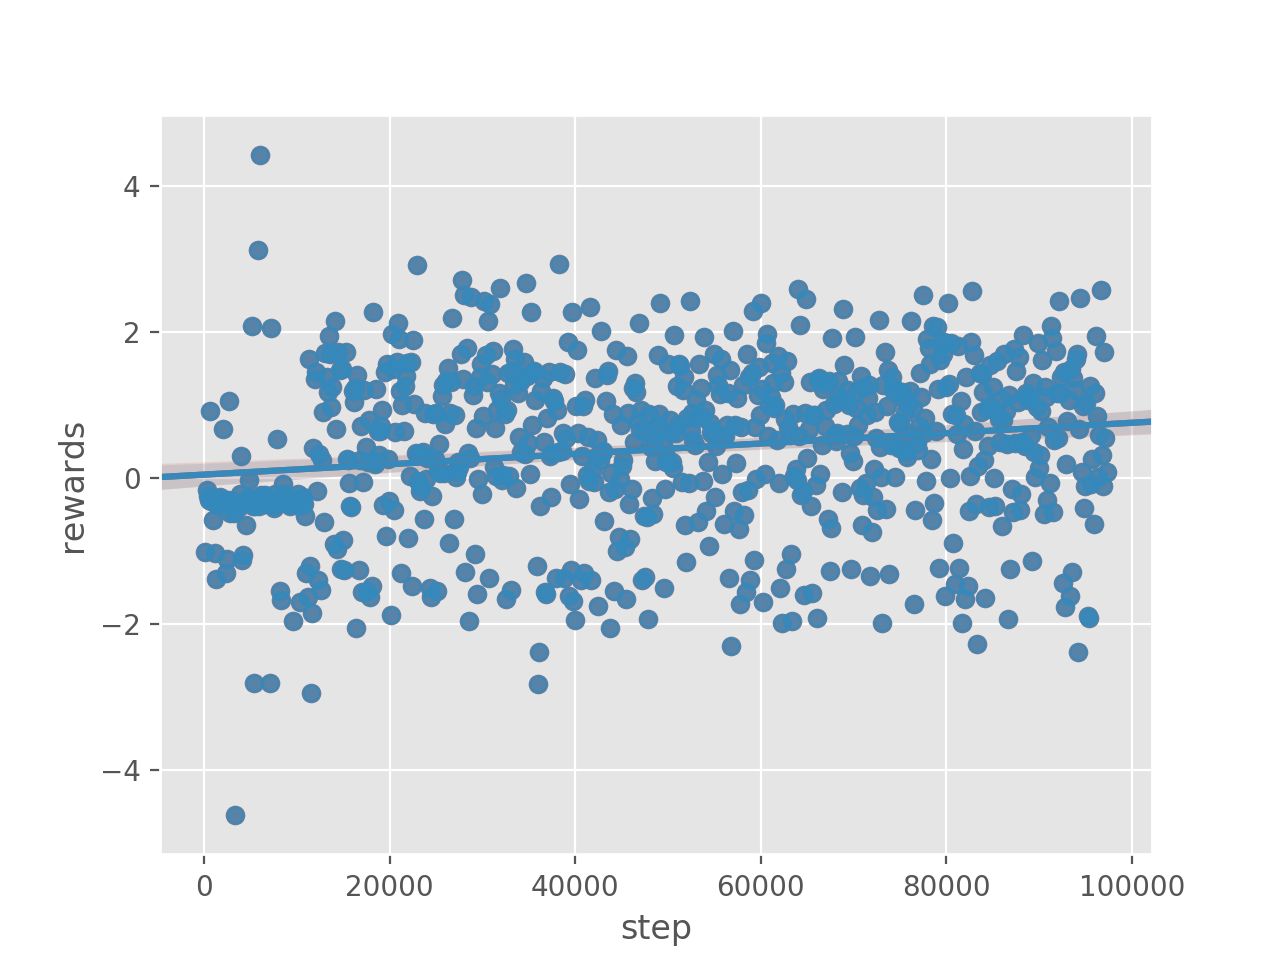

In [17]:
# plot rewards
plt.figure()
df_online, df = load_stats_ddpg(agent)
sns.regplot(x="step", y="rewards", data=df_online, order=1)
thisPlt = sns.regplot(x="step", y="rewards", data=df_online, order=1)
thisPlt = thisPlt.get_figure()
thisPlt.savefig('training_fig.png')

try:
    resultsBot.training_finished()
except TelegramError:
    pass

In [18]:
# monthly growth
portfolio_return = (1+df_online.rewards[-100:].mean())

returns = task.unwrapped.src.data[0,:,:1]
market_return = (1+returns).mean()
market_return, portfolio_return

(161.88318, 1.5701505499236823)

# Test

In [19]:
def test_algo(env, algo, seed=0):
    """
    Runs and algo from https://github.com/Marigold/universal-portfolios on env
    
    https://github.com/Marigold/universal-portfolios/commit/e8970a82427522ef11b1c3cbf681e18b5fe8169c
    """
    env.seed(0)
    np.random.seed(0)

    state = env.reset()
    for i in range(env.unwrapped.sim.steps):
        
        history= pd.DataFrame(state[0,:,:], columns=env.unwrapped.src.asset_names)
        # MPT wants a cash column, and it should be first
        history['CASH']=1
        history=history[['CASH'] + env.unwrapped.src.asset_names]
#         cols = list(history.columns)
#         cols[0]='CASH'
#         history.columns = cols
        
        x=history.iloc[-1]
        
        last_b = env.unwrapped.sim.w0#[1:]

        algo.init_step(history)
        # some don't want history
        try:
            action = algo.step(x, last_b, history)
        except TypeError:
            action = algo.step(x, last_b)
        
        # might by dataframe
        action = getattr(action, 'value', action)
        
        # For upt
        if isinstance(action, np.matrixlib.defmatrix.matrix):
            action = np.array(action.tolist()).T[0]
            
        

        state, reward, done, info = env.step(action)

        if done:
            break   
    df = pd.DataFrame(env.unwrapped.infos)
    df.index = pd.to_datetime(df['date']*1e9)
    return df['portfolio_value'], df

<IPython.core.display.Javascript object>


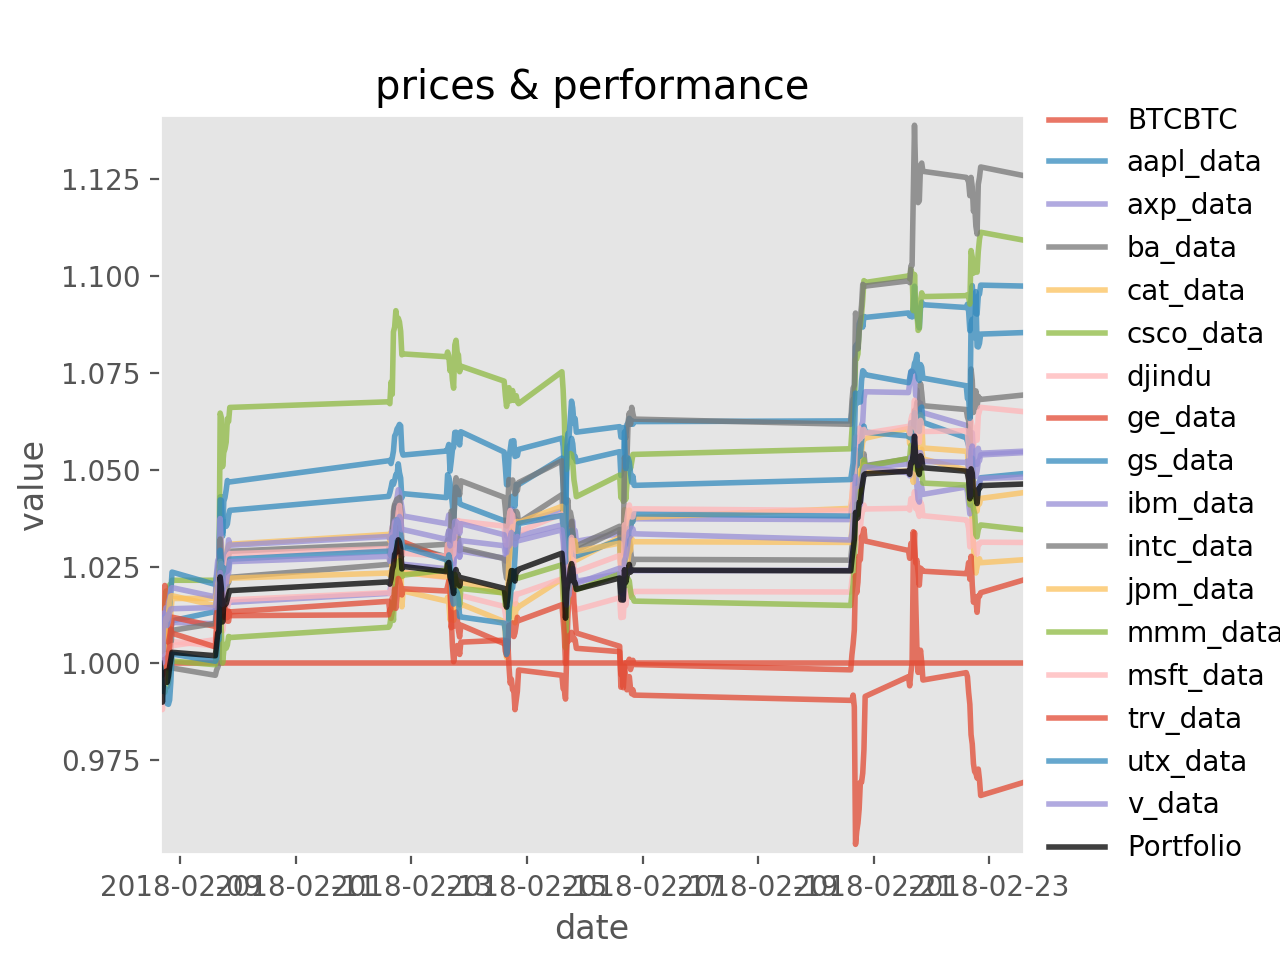

<IPython.core.display.Javascript object>


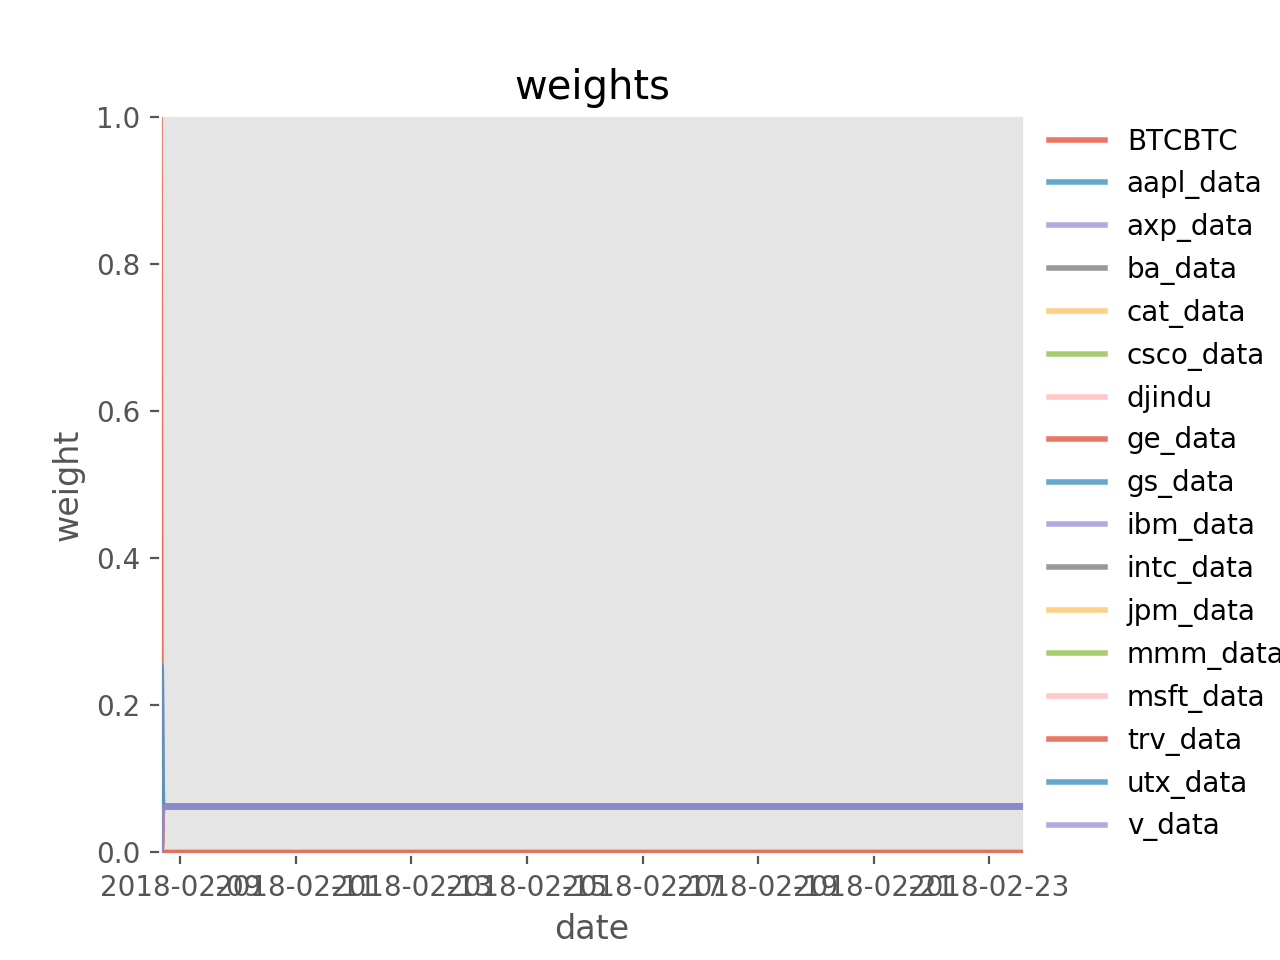

<IPython.core.display.Javascript object>


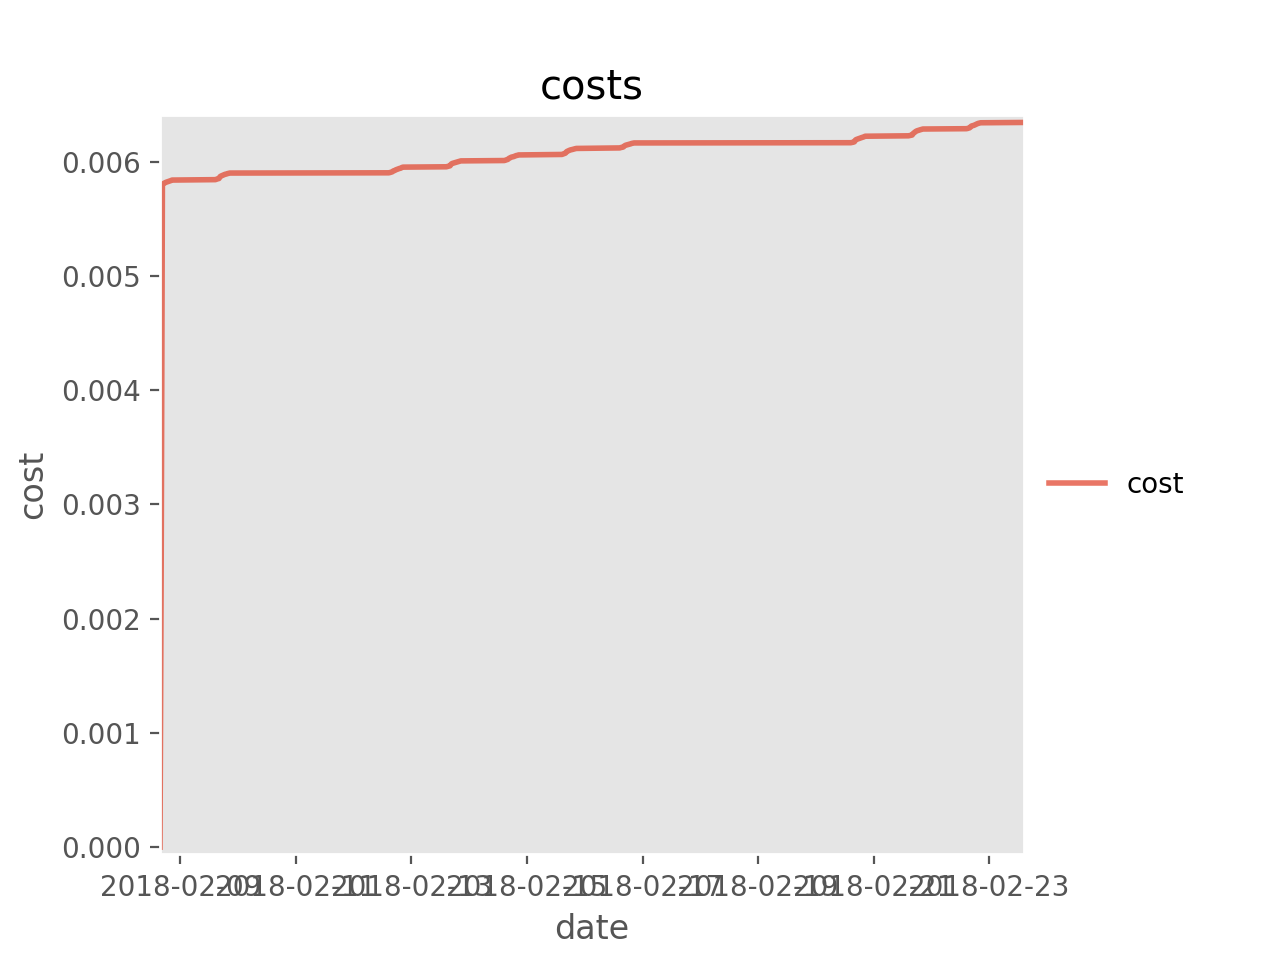

In [20]:
# use test env
df_test = pd.read_hdf('./data/bloomberg_30m.hf',key='test')
test_steps=3000
env_test = task_fn_test()
agent.task = env_test
agent.config.max_episode_length = test_steps
agent.task.reset()
np.random.seed(0)

# run in deterministic mode, no training, no exploration
agent.episode(True)
agent.task.render('notebook')
agent.task.render('notebook', True)
plt.savefig('testing_fig.png', bbox_inches = 'tight', dpi = 800)

df = pd.DataFrame(agent.task.unwrapped.infos)
df.index = pd.to_datetime(df['date']*1e9)

try:
    resultsBot.testing_finished()
except TelegramError:
    pass

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


BestSoFar
ONS
RMR


<IPython.core.display.Javascript object>


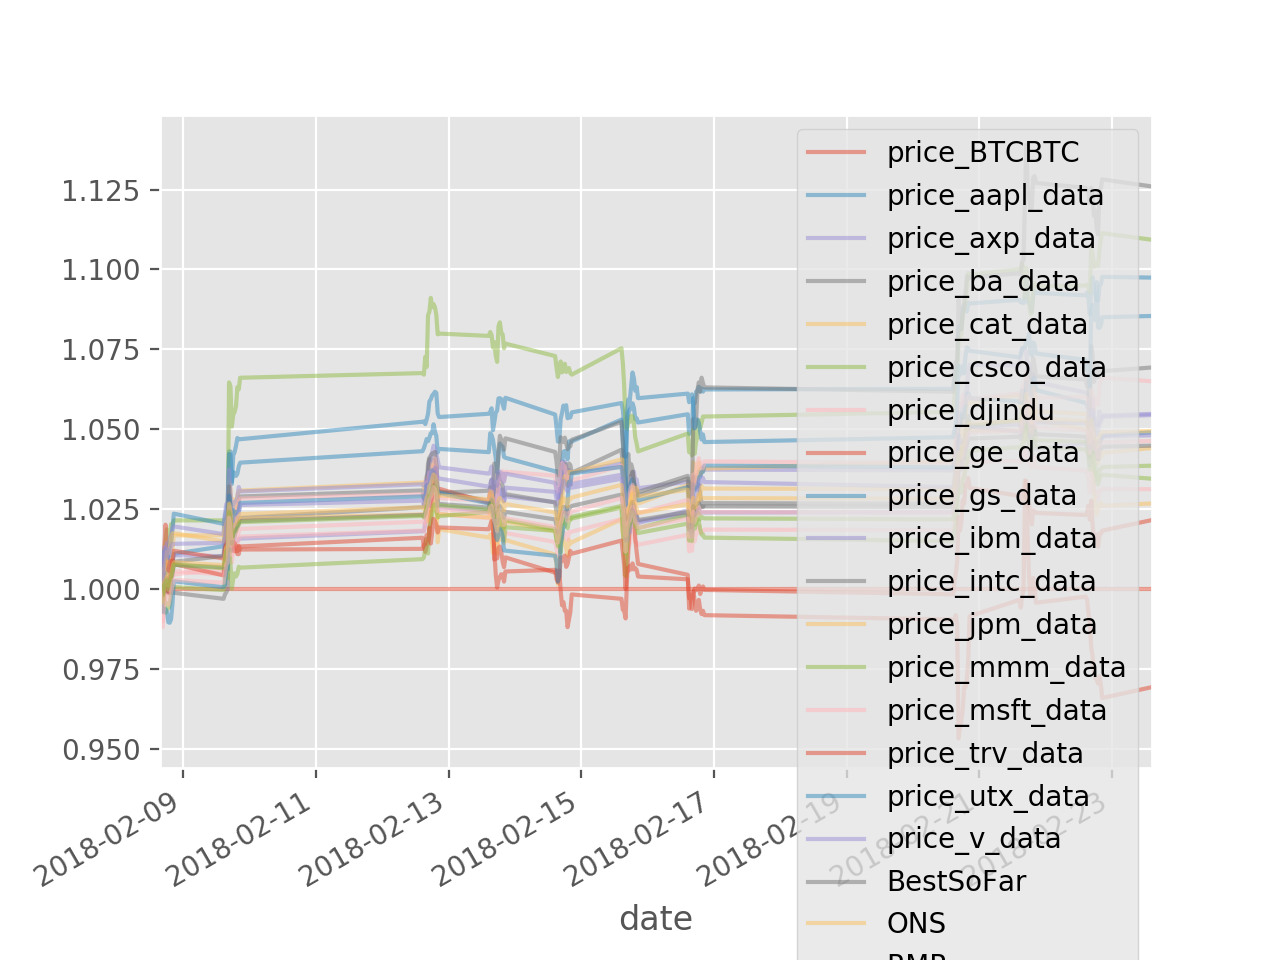

In [21]:
from universal import algos
env = task.unwrapped
price_cols = [col for col in df.columns if col.startswith('price')]
for col in price_cols:
    df[col]=df[col].cumprod()

df = df[price_cols + ['portfolio_value']]
    
algo_dict=dict(
    # Pick the same is in https://arxiv.org/pdf/1706.10059.pdf
    # Benchmarks
#     UCRP=algos.UP(),
    
    # Follow the winner
    BestSoFar=algos.BestSoFar(cov_window=env_test.unwrapped.src.window_length-1),
#     UniversalPortfolio=algos.UP(eval_points=1000),
    ONS=algos.ONS(),
    
    # Follow the loser
#     OnlineMovingAverageReversion=algos.OLMAR(window=env.src.window_length-1, eps=10), 
    RMR=algos.RMR(window=env_test.unwrapped.src.window_length-1, eps=10),
#     PassiveAggressiveMeanReversion=algos.PAMR(),
    
    # Pattern matching
    #     CorrelationDrivenNonparametricLearning=algos.CORN(window=30),
)
for name, algo in algo_dict.items():
    print(name)
    perf, _ = test_algo(env_test, algo)
    perf.index=df.index
    df[name]=perf

# put portfolio value at end so we plot it on top and can therefore see it
cols = list(df.columns.drop('portfolio_value'))+['portfolio_value']
df=df[cols]


df.plot(alpha=0.5)
plt.savefig('best_fig.png', bbox_inches = 'tight', dpi = 800)

try:
    resultsBot.best_comparison()
except TelegramError:
    pass